In [1]:
import numpy as np
import pandas as pd

dense_mat = pd.read_csv('mat.csv', index_col = 0).values
mat = dense_mat[165 : 240, 4 * 288 + 72 : 4 * 288 + 144]
np.save('toy_data.npy', mat)

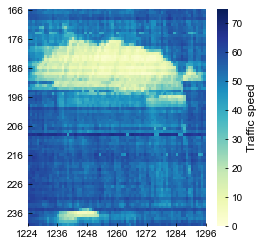

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mat = np.load('toy_data.npy')

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Arial'

fig = plt.figure(figsize = (4, 4))
sns.heatmap(mat, cmap = 'YlGnBu', cbar_kws={'label': 'Traffic speed'}, vmin = 0, vmax = 75)
plt.xticks(np.arange(0, 72 + 1, 12), np.arange(4 * 288 + 72, 4 * 288 + 144 + 1, 12), rotation = 0)
plt.yticks(np.arange(0.5, 75.5, 10), np.arange(166, 241, 10), rotation = 0)
plt.show()

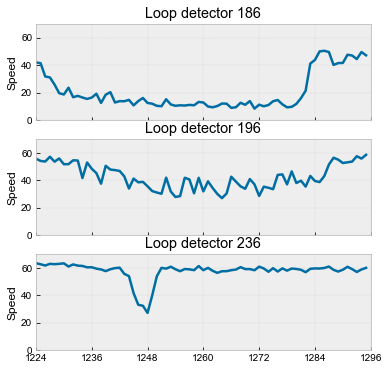

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6, 6))
i = 1
for loc in [185, 195, 235]:
    ax = fig.add_subplot(3, 1, i)
    plt.plot(mat[loc - 166, :], color = "#006ea3", linewidth = 2.5)
    plt.xticks(np.arange(0, 72 + 1, 12), 
               np.arange(4 * 288 + 72, 4 * 288 + 144 + 1, 12))
    if i != 3:
        plt.setp(ax.get_xticklabels(), visible = False)
    plt.grid(axis = 'both', linestyle = "--", linewidth = 0.1, color = 'gray')
    plt.ylabel('Speed')
    plt.title('Loop detector {}'.format(loc + 1))
    ax.tick_params(direction = "in")
    ax.set_xlim([0, 72])
    ax.set_ylim([0, 70])
    i += 1
plt.show()

In [4]:
import numpy as np

def DMD(data, r):
    """Dynamic Mode Decomposition (DMD) algorithm."""
    
    ## Build data matrices
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    eigval, eigvec = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ eigvec
    
    return eigval, eigvec, Psi

In [5]:
r = 5
eigval, eigvec, Psi = DMD(mat, r)

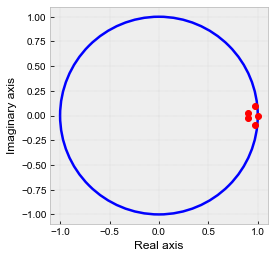

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal', adjustable = 'box')
plt.plot(eigval.real, eigval.imag, 'o', color = 'red', markersize = 6)
circle = plt.Circle((0, 0), 1, color = 'blue', linewidth = 2.5, fill = False)
ax.add_patch(circle)
plt.grid(axis = 'both', linestyle = "--", linewidth = 0.1, color = 'gray')
ax.tick_params(direction = "in")
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.show()

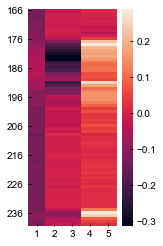

In [7]:
fig = plt.figure(figsize = (2, 4))
sns.heatmap(Psi.real)
plt.xticks(np.arange(0.5, 5.5), np.arange(1, 6), rotation = 0)
plt.yticks(np.arange(0.5, 75.5, 10), np.arange(166, 241, 10), rotation = 0)
plt.show()

In [8]:
def reconstruct_DMD_system(data, r):
    T = data.shape[1]
    ## Build data matrices
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    eigval, eigvec = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ eigvec
    time_dynamics = np.zeros((r, T), dtype = 'complex')
    b = np.linalg.pinv(Psi) @ data[:, 0]
    for t in range(T):
        time_dynamics[:, t] = np.power(eigval, t + 1) * b
    return (Psi @ time_dynamics).real, time_dynamics.real

In [9]:
r = 5
rec_system, time_dynamics = reconstruct_DMD_system(mat, r)

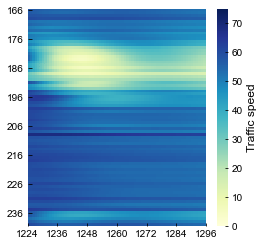

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mat = np.load('toy_data.npy')

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Arial'

fig = plt.figure(figsize = (4, 4))
sns.heatmap(rec_system, cmap = 'YlGnBu', cbar_kws={'label': 'Traffic speed'}, vmin = 0, vmax = 75)
plt.xticks(np.arange(0, 72 + 1, 12), np.arange(4 * 288 + 72, 4 * 288 + 144 + 1, 12), rotation = 0)
plt.yticks(np.arange(0.5, 75.5, 10), np.arange(166, 241, 10), rotation = 0)
plt.show()

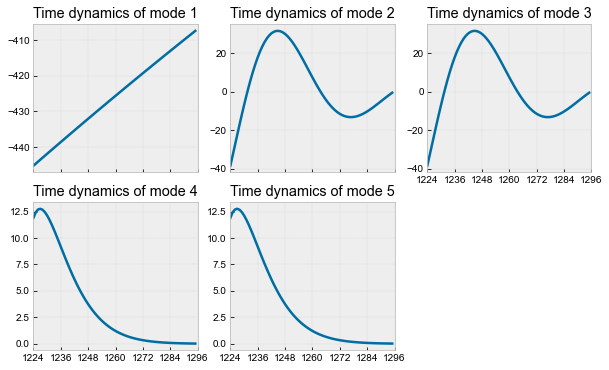

In [11]:
fig = plt.figure(figsize = (10, 6))
for loc in range(1, 6):
    ax = fig.add_subplot(2, 3, loc)
    plt.plot(time_dynamics[loc - 1, :], color = "#006ea3", linewidth = 2.5)
    plt.xticks(np.arange(0, 72 + 1, 12), 
               np.arange(4 * 288 + 72, 4 * 288 + 144 + 1, 12))
    if loc == 1 or loc == 2:
        plt.setp(ax.get_xticklabels(), visible = False)
    plt.grid(axis = 'both', linestyle = "--", linewidth = 0.1, color = 'gray')
    plt.title('Time dynamics of mode {}'.format(loc))
    ax.tick_params(direction = "in")
    ax.set_xlim([0, 72])
plt.show()

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>